In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics  
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC, LinearSVR, SVR
from sklearn.inspection import permutation_importance

In [67]:
df = pd.read_csv('df_lm.csv').drop(['Unnamed: 0', 'typDM'], axis=1)

In [68]:
pd.isna(df).sum()

AHI                             0
BID                             0
Sex                             0
Sy_spankove_apnoe               0
age                             0
BMI                             5
delka_DM                      323
smoking.status                  0
DM                              0
hypertenze                      0
ischemicka_choroba_srdecni      0
IM                              0
I50                             0
I64                             0
cevni_choroby_mozku             0
arytmie                         0
jatra                           0
obezita                         0
hyperlipidemie                  0
astma                           0
hypotyreóza                     0
ledviny                         0
Tx                              0
dtype: int64

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AHI                         358 non-null    float64
 1   BID                         358 non-null    object 
 2   Sex                         358 non-null    object 
 3   Sy_spankove_apnoe           358 non-null    object 
 4   age                         358 non-null    float64
 5   BMI                         272 non-null    float64
 6   delka_DM                    35 non-null     float64
 7   DM                          358 non-null    int64  
 8   hypertenze                  358 non-null    int64  
 9   smoking.status              358 non-null    int64  
 10  ischemicka_choroba_srdecni  358 non-null    int64  
 11  IM                          358 non-null    int64  
 12  I50                         358 non-null    int64  
 13  I64                         358 non

In [190]:
df['Sy_spankove_apnoe'].value_counts()

Sy_spankove_apnoe
Lehký             113
Normální nález     98
Těžký              78
Středně těžký      69
Name: count, dtype: int64

In [191]:
round(df['Sy_spankove_apnoe'].value_counts() / len(df), 2)

Sy_spankove_apnoe
Lehký             0.32
Normální nález    0.27
Těžký             0.22
Středně těžký     0.19
Name: count, dtype: float64

In [192]:
df[['age', 'BMI']].describe()

,age,BMI
count,358.000000,272.000000
mean,59.737942,35.378676
std,10.751143,5.420508
min,19.296372,22.500000
25%,52.781821,31.500000
50%,60.811938,34.750000
75%,68.217824,38.700000
max,88.787297,52.800000


In [6]:
df.head()

,AHI,BID,Sex,Sy_spankove_apnoe,age,BMI,delka_DM,smoking.status,DM,hypertenze,...,I50,I64,cevni_choroby_mozku,arytmie,jatra,obezita,hyperlipidemie,astma,hypotyreóza,ledvidy
0,8.0,641117/1734,1.0,Lehký,59.495031,NaN,32.0,1,1,1,...,0,0,0,0,0,0,1,0,0,0
1,30.0,581009/0913,1.0,Těžký,65.603177,NaN,47.0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,10.0,625222/0216,0.0,Lehký,62.230144,NaN,NaN,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,51.0,495906/271,0.0,Těžký,74.692955,39.1,NaN,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,33.0,540626/1047,1.0,Těžký,69.890651,31.2,NaN,1,1,1,...,0,0,0,1,0,0,1,0,0,0


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'BMI'}>]],
      dtype=object)

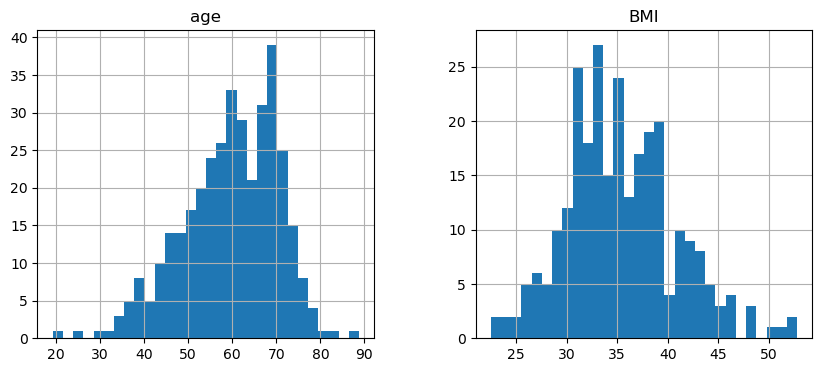

In [195]:
%matplotlib inline
df[['age', 'BMI']].hist(bins=30, figsize=(10,4))

In [214]:
corr_matrix = df.drop(['BID', 'Sy_spankove_apnoe'], axis=1).corr()

In [215]:
corr_matrix.style.background_gradient(cmap='BrBG_r')
# 'RdBu_r', 'coolwarm', & PuOr_r are other colormaps

,AHI,Sex,age,BMI,delka_DM,smoking.status,DM,hypertenze,ischemicka_choroba_srdecni,IM,I50,I64,cevni_choroby_mozku,arytmie,jatra,obezita,hyperlipidemie,astma,hypotyreóza,ledvidy
AHI,1.000000,0.141472,0.009368,0.242154,0.110934,0.005371,0.149569,-0.055280,0.140847,-0.007771,-0.007771,0.032885,0.096609,0.096366,-0.063372,0.025119,-0.005430,0.012047,0.075806,0.019884
Sex,0.141472,1.000000,-0.087051,-0.142486,0.028395,-0.097077,0.124966,0.030402,0.126077,-0.029161,-0.029161,-0.044938,-0.050386,0.090365,-0.036036,0.030061,0.110028,-0.024273,-0.137308,0.006710
age,0.009368,-0.087051,1.000000,-0.229149,0.205178,-0.108602,0.132303,0.147970,0.113283,0.067564,0.067564,0.125191,0.128297,0.093046,0.020032,-0.093980,0.197342,-0.035588,0.071761,-0.025960
BMI,0.242154,-0.142486,-0.229149,1.000000,-0.010233,0.151344,-0.084343,0.156579,0.037123,0.111504,0.111504,-0.080465,-0.124256,-0.018149,0.003644,0.290606,-0.017942,0.104751,0.003177,-0.024831
delka_DM,0.110934,0.028395,0.205178,-0.010233,1.000000,0.244303,nan,0.183642,nan,0.008673,0.008673,0.150059,0.150059,0.058320,-0.151098,-0.116272,-0.030737,-0.184189,0.148601,-0.165889
smoking.status,0.005371,-0.097077,-0.108602,0.151344,0.244303,1.000000,0.099598,-0.052455,-0.002739,-0.017256,-0.017256,-0.058922,-0.066066,-0.047692,-0.017275,-0.007523,-0.002214,0.046132,0.056832,-0.079442
DM,0.149569,0.124966,0.132303,-0.084343,nan,0.099598,1.000000,0.089505,0.131038,-0.094402,-0.094402,-0.030143,-0.033798,0.165485,-0.018994,-0.067632,0.056800,0.001249,-0.063859,0.145371
hypertenze,-0.055280,0.030402,0.147970,0.156579,0.183642,-0.052455,0.089505,1.000000,0.165356,0.052549,0.052549,-0.077915,-0.087361,0.025720,-0.037130,0.159747,0.261739,0.043740,0.005943,0.089912
ischemicka_choroba_srdecni,0.140847,0.126077,0.113283,0.037123,nan,-0.002739,0.131038,0.165356,1.000000,0.166183,0.166183,0.087844,0.128632,0.142834,-0.054820,0.097959,0.106757,0.110489,0.040848,0.100105
IM,-0.007771,-0.029161,0.067564,0.111504,0.008673,-0.017256,-0.094402,0.052549,0.166183,1.000000,1.000000,0.077495,0.058352,0.079147,-0.058609,0.083911,-0.009841,0.168123,-0.009536,0.138754


In [216]:
corr_matrix['AHI'].sort_values()

jatra                        -0.063372
hypertenze                   -0.055280
IM                           -0.007771
I50                          -0.007771
hyperlipidemie               -0.005430
smoking.status                0.005371
age                           0.009368
astma                         0.012047
ledvidy                       0.019884
obezita                       0.025119
I64                           0.032885
hypotyreóza                   0.075806
arytmie                       0.096366
cevni_choroby_mozku           0.096609
delka_DM                      0.110934
ischemicka_choroba_srdecni    0.140847
Sex                           0.141472
DM                            0.149569
BMI                           0.242154
AHI                           1.000000
Name: AHI, dtype: float64

In [70]:
# mi missing BMI with LinReg using 'Sex', 'age' predictors
df_copy = df.drop(['BID'], axis=1).copy()

X = df_copy[['Sex', 'age']]
y = df_copy['BMI']

missing_mask = y.isna()

X_train = X[~missing_mask]
y_train = y[~missing_mask]
X_predict = X[missing_mask]

regressor = LinearRegression()
regressor.fit(X_train, y_train)

predicted_bmi = regressor.predict(X_predict)

df_copy.loc[missing_mask, 'BMI'] = predicted_bmi

pd.isna(df_copy).sum()

AHI                             0
Sex                             0
Sy_spankove_apnoe               0
age                             0
BMI                             0
delka_DM                      323
smoking.status                  0
DM                              0
hypertenze                      0
ischemicka_choroba_srdecni      0
IM                              0
I50                             0
I64                             0
cevni_choroby_mozku             0
arytmie                         0
jatra                           0
obezita                         0
hyperlipidemie                  0
astma                           0
hypotyreóza                     0
ledviny                         0
Tx                              0
dtype: int64

array([[<Axes: title={'center': 'BMI'}>]], dtype=object)

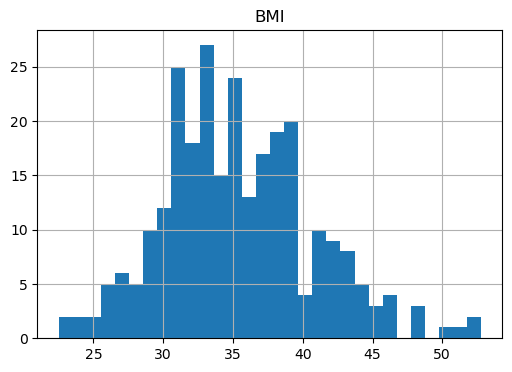

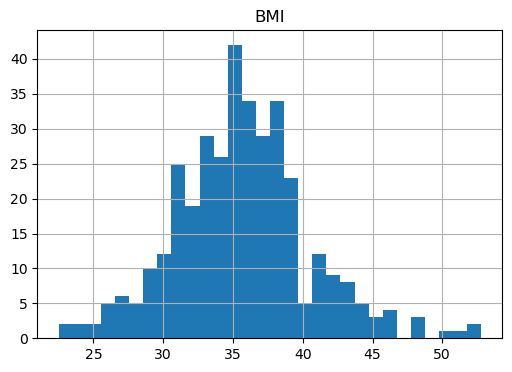

In [242]:
%matplotlib inline
df[['BMI']].hist(bins=30, figsize=(6,4))
df_copy[['BMI']].hist(bins=30, figsize=(6,4))

### Create pipelines

In [228]:
X.columns.to_list() 

['age',
 'BMI',
 'delka_DM',
 'smoking.status',
 'DM',
 'hypertenze',
 'ischemicka_choroba_srdecni',
 'IM',
 'I50',
 'I64',
 'cevni_choroby_mozku',
 'arytmie',
 'jatra',
 'obezita',
 'hyperlipidemie',
 'astma',
 'hypotyreóza',
 'ledviny',
 'Tx',
 'Sex']

In [262]:
df = pd.read_csv('df_lm.csv').drop(['Unnamed: 0', 'typDM', 'BID'], axis=1)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    # ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaled', StandardScaler()),
])
df_num = df.drop(['Sex', 'Sy_spankove_apnoe'], axis=1)
num_attributes = list(df_num)
cat_attributes = ['Sex', 'Sy_spankove_apnoe']
attributes = num_attributes + cat_attributes

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', OrdinalEncoder(), cat_attributes),
])

df_prepared = full_pipeline.fit_transform(df)
df_copy = pd.DataFrame(df_prepared, columns=attributes)

X = df_copy.drop(['Sy_spankove_apnoe', 'AHI'], axis=1)
y = df_copy['AHI']

In [263]:
ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in ss.split(X, y):
    strat_train = df_copy.loc[train_index]
    strat_test = df_copy.loc[test_index]

X_train = strat_train.drop(columns=['AHI','Sy_spankove_apnoe'], axis=1)
y_train = strat_train['AHI']
X_test = strat_test.drop(columns=['AHI','Sy_spankove_apnoe'], axis=1)
y_test = strat_test['AHI']

In [264]:
rf_reg = RandomForestRegressor()

pipeline = Pipeline(steps=[
    ('regressor', rf_reg)
])

param_grid = [
    {'regressor__n_estimators': [3, 10, 30, 50, 100], 'regressor__max_features': [2, 5, 10, 15]},
    {'regressor__bootstrap': [False], 'regressor__n_estimators': [3, 10, 30, 100], 'regressor__max_features': [2, 10, 15]}
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=3)
grid_search.fit(X_train, y_train)
best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps['regressor']
feature_importances = best_model.feature_importances_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-0.368, test=-1.430) total time=   0.0s
[CV 2/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-0.267, test=-1.340) total time=   0.0s
[CV 3/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-0.468, test=-1.052) total time=   0.0s
[CV 4/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-0.291, test=-1.185) total time=   0.0s
[CV 5/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-0.276, test=-1.343) total time=   0.0s
[CV 1/5] END regressor__max_features=2, regressor__n_estimators=10;, score=(train=-0.198, test=-1.180) total time=   0.0s
[CV 2/5] END regressor__max_features=2, regressor__n_estimators=10;, score=(train=-0.192, test=-1.164) total time=   0.0s
[CV 3/5] END regressor__max_features=2, regressor__n_estimators=10;, score=(train=-0.184,

In [266]:
# BMI mi mean
feature_importances_df = pd.DataFrame({
        'Feature': X_train.columns.to_list(),
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
print(feature_importances_df)

                       Feature  Importance
1                          BMI    0.377395
0                          age    0.258070
19                         Sex    0.050602
13                     obezita    0.036840
4                           DM    0.036681
5                   hypertenze    0.035774
16                 hypotyreóza    0.033074
3               smoking.status    0.030069
14              hyperlipidemie    0.025448
6   ischemicka_choroba_srdecni    0.018659
2                     delka_DM    0.017574
17                     ledviny    0.016083
15                       astma    0.013755
7                           IM    0.009028
11                     arytmie    0.008798
8                          I50    0.008082
18                          Tx    0.006990
9                          I64    0.006570
12                       jatra    0.006186
10         cevni_choroby_mozku    0.004322


In [261]:
# BMI mi meadian
feature_importances_df = pd.DataFrame({
        'Feature': X_train.columns.to_list(),
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
print(feature_importances_df)

                       Feature  Importance
1                          BMI    0.378925
0                          age    0.259214
19                         Sex    0.047681
13                     obezita    0.039100
5                   hypertenze    0.038351
4                           DM    0.034495
14              hyperlipidemie    0.029070
16                 hypotyreóza    0.028695
3               smoking.status    0.024341
6   ischemicka_choroba_srdecni    0.020386
2                     delka_DM    0.019429
17                     ledviny    0.017187
8                          I50    0.010970
15                       astma    0.010834
7                           IM    0.009219
18                          Tx    0.008120
11                     arytmie    0.007207
9                          I64    0.006812
10         cevni_choroby_mozku    0.005433
12                       jatra    0.004531


### RF regression

In [297]:
X = df_copy[['Sex', 'age', 'BMI', 'delka_DM', 'smoking.status', 'hypertenze', 'ischemicka_choroba_srdecni', 'DM', 'hyperlipidemie', 'hypotyreóza']]
y = df_copy['AHI']

# Initialize ShuffleSplit
ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in ss.split(X, y):
    strat_train = df_copy.loc[train_index]
    strat_test = df_copy.loc[test_index]

# Split the data into features and target for training and testing sets
X_train = strat_train.drop(columns=['AHI'])
y_train = strat_train['AHI']
X_test = strat_test.drop(columns=['AHI'])
y_test = strat_test['AHI']

# Define preprocessing for numeric columns (impute missing values)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = SimpleImputer(strategy='mean')

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
rf_reg = RandomForestRegressor()

# Create a pipeline that first preprocesses the data and then fits the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_reg)
])

# Define the parameter grid for grid search
param_grid = [
    {'regressor__n_estimators': [3, 10, 30, 50, 100], 'regressor__max_features': [2, 5, 10, 15]},
    {'regressor__bootstrap': [False], 'regressor__n_estimators': [3, 10, 30, 100], 'regressor__max_features': [2, 10, 15]}
]

# Initialize GridSearchCV with more verbosity
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=3)

try:
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
except Exception as e:
    print(f"An error occurred: {e}")

# Check the results of the grid search
if grid_search.best_params_ is not None:
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)
    
    # Extract the best estimator from the grid search
    best_pipeline = grid_search.best_estimator_
    best_model = best_pipeline.named_steps['regressor']
    
    # Get feature importances
    feature_importances = best_model.feature_importances_
    
    numeric_feature_names = numeric_features.tolist()
    categorical_feature_names = categorical_features.tolist()
    
    feature_names = numeric_feature_names + categorical_feature_names
    
    feature_importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print(feature_importances_df)
else:
    print("Grid search did not find any valid parameter combinations.")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-131.874, test=-601.583) total time=   0.0s
[CV 2/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-134.761, test=-406.513) total time=   0.0s
[CV 3/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-137.208, test=-402.034) total time=   0.0s
[CV 4/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-128.711, test=-323.588) total time=   0.0s
[CV 5/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-122.793, test=-715.708) total time=   0.0s
[CV 1/5] END regressor__max_features=2, regressor__n_estimators=10;, score=(train=-56.862, test=-451.199) total time=   0.0s
[CV 2/5] END regressor__max_features=2, regressor__n_estimators=10;, score=(train=-76.691, test=-405.774) total time=   0.0s
[CV 3/5] END regressor__max_features=2, regressor__n_estimators

In [418]:
X = df_copy.drop(['Sy_spankove_apnoe', 'AHI'], axis=1)
y = df_copy['AHI']

# Define preprocessing for numeric columns (impute missing values)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = SimpleImputer(strategy='mean')

# Define preprocessing for categorical columns (one-hot encode)
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
rf_reg = RandomForestRegressor()

# Create a pipeline that first preprocesses the data and then fits the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_reg)
])

# Define the parameter grid for grid search
param_grid = [
    {'regressor__n_estimators': [3, 10, 30, 50, 100], 'regressor__max_features': [2, 5, 10, 15]},
    {'regressor__bootstrap': [False], 'regressor__n_estimators': [3, 10, 30, 100], 'regressor__max_features': [2, 10, 15]}
]

# Initialize ShuffleSplit
ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in ss.split(X, y):
    strat_train = df_copy.loc[train_index]
    strat_test = df_copy.loc[test_index]

# Split the data into features and target for training and testing sets
X_train = strat_train.drop(columns=['AHI'])
y_train = strat_train['AHI']
X_test = strat_test.drop(columns=['AHI'])
y_test = strat_test['AHI']

# Initialize GridSearchCV with more verbosity
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=3)

try:
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
except Exception as e:
    print(f"An error occurred: {e}")

# Check the results of the grid search
if grid_search.best_params_ is not None:
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)
    
    # Extract the best estimator from the grid search
    best_pipeline = grid_search.best_estimator_
    best_model = best_pipeline.named_steps['regressor']
    
    # Get feature importances
    feature_importances = best_model.feature_importances_
    
    numeric_feature_names = numeric_features.tolist()
    categorical_feature_names = categorical_features.tolist()
    
    feature_names = numeric_feature_names + categorical_feature_names
    
    feature_importances_rfr = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print(feature_importances_rfr)
else:
    print("Grid search did not find any valid parameter combinations.")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-132.304, test=-606.564) total time=   0.0s
[CV 2/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-124.836, test=-433.411) total time=   0.0s
[CV 3/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-125.567, test=-426.058) total time=   0.0s
[CV 4/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-136.247, test=-261.379) total time=   0.0s
[CV 5/5] END regressor__max_features=2, regressor__n_estimators=3;, score=(train=-112.646, test=-433.959) total time=   0.0s
[CV 1/5] END regressor__max_features=2, regressor__n_estimators=10;, score=(train=-65.575, test=-481.759) total time=   0.0s
[CV 2/5] END regressor__max_features=2, regressor__n_estimators=10;, score=(train=-85.185, test=-442.097) total time=   0.0s
[CV 3/5] END regressor__max_features=2, regressor__n_estimators

/tmp/ipykernel_2147270/2826040316.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_rfr, palette='viridis')


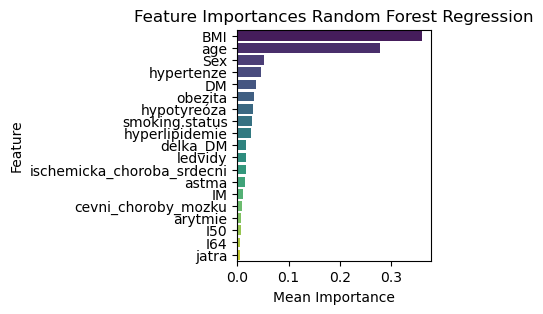

In [462]:
plt.figure(figsize=(2.5,3))

sns.barplot(x='Importance', y='Feature', data=feature_importances_rfr, palette='viridis')

plt.title('Feature Importances Random Forest Regression')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')

plt.show()

### NB

In [415]:
X = df_copy.drop(['Sy_spankove_apnoe', 'AHI'], axis=1)
y = df_copy['Sy_spankove_apnoe']

# Define preprocessing for numeric columns (impute missing values and scale)
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that first preprocesses the data and then fits the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in ss.split(X, y):
    strat_train = df_copy.loc[train_index]
    strat_test = df_copy.loc[test_index]

X_train = strat_train.drop(columns=['Sy_spankove_apnoe'])
y_train = strat_train['Sy_spankove_apnoe']
X_test = strat_test.drop(columns=['Sy_spankove_apnoe'])
y_test = strat_test['Sy_spankove_apnoe']

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)


print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
                precision    recall  f1-score   support

         Lehký       1.00      0.00      0.00        26
Normální nález       0.37      0.92      0.52        24
 Středně těžký       0.00      0.00      0.00        14
         Těžký       0.40      0.25      0.31         8

      accuracy                           0.33        72
     macro avg       0.44      0.29      0.21        72
  weighted avg       0.53      0.33      0.21        72

Confusion Matrix:
[[ 0 20  5  1]
 [ 0 22  1  1]
 [ 0 13  0  1]
 [ 0  5  1  2]]


### RF classifier

In [424]:
rf_clf = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_clf)
])


param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    # 'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': [10, 20, 30],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)

ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in ss.split(X, y):
    strat_train = df_copy.loc[train_index]
    strat_test = df_copy.loc[test_index]

X_train = strat_train.drop(columns=['Sy_spankove_apnoe'])
y_train = strat_train['Sy_spankove_apnoe']
X_test = strat_test.drop(columns=['Sy_spankove_apnoe'])
y_test = strat_test['Sy_spankove_apnoe']

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

best_model = grid_search.best_estimator_.named_steps['classifier']
feature_importances_rfc = best_model.feature_importances_

numeric_feature_names = numeric_features.tolist()
categorical_feature_names = categorical_features.tolist()
    
feature_names_rfc = numeric_feature_names + categorical_feature_names

feature_importances_rfc = pd.DataFrame({
    'Feature': feature_names_rfc,
    'Importance': feature_importances_rfc
}).sort_values(by='Importance', ascending=False)

print(feature_importances_rfc)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 5/5] END classifier__bootstrap=True, classifier__max_depth=30, classifier__n_estimators=100;, score=0.316 total time=   0.1s
[CV 3/5] END classifier__bootstrap=True, classifier__max_depth=30, classifier__n_estimators=200;, score=0.298 total time=   0.2s
[CV 4/5] END classifier__bootstrap=True, classifier__max_depth=30, classifier__n_estimators=200;, score=0.386 total time=   0.2s
[CV 2/5] END classifier__bootstrap=False, classifier__max_depth=10, classifier__n_estimators=50;, score=0.316 total time=   0.0s
[CV 3/5] END classifier__bootstrap=False, classifier__max_depth=10, classifier__n_estimators=50;, score=0.333 total time=   0.0s
[CV 4/5] END classifier__bootstrap=False, classifier__max_depth=10, classifier__n_estimators=50;, score=0.421 total time=   0.0s
[CV 5/5] END classifier__bootstrap=False, classifier__max_depth=10, classifier__n_estimators=50;, score=0.281 total time=   0.0s
[CV 3/5] END classifier__bootstrap=F

/tmp/ipykernel_2147270/992732328.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_rfc, palette='viridis')


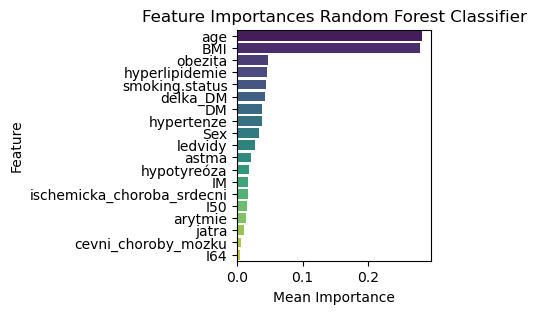

In [460]:
plt.figure(figsize=(2.5,3))

sns.barplot(x='Importance', y='Feature', data=feature_importances_rfc, palette='viridis')

plt.title('Feature Importances Random Forest Classifier')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')

plt.show()

In [349]:
feature_importances_df

,Feature,Importance
2,BMI,0.262126
1,age,0.247572
14,obezita,0.051021
0,Sex,0.046505
3,delka_DM,0.044739
4,smoking.status,0.043535
15,hyperlipidemie,0.043037
5,DM,0.041410
6,hypertenze,0.031512
17,hypotyreóza,0.027707


### SVM

In [443]:
X = df_copy.drop(['Sy_spankove_apnoe', 'AHI', 'delka_DM'], axis=1)
y = df_copy['Sy_spankove_apnoe']

ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in ss.split(X, y):
    strat_train = df_copy.loc[train_index]
    strat_test = df_copy.loc[test_index]

X_train = strat_train.drop(columns=['Sy_spankove_apnoe', 'AHI', 'delka_DM'])
y_train = strat_train['Sy_spankove_apnoe']
X_test = strat_test.drop(columns=['Sy_spankove_apnoe', 'AHI', 'delka_DM'])
y_test = strat_test['Sy_spankove_apnoe']

svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])

svm_clf.fit(X_train, y_train)
pred_svm = svm_clf.predict(X_test)
print(confusion_matrix(y_test, pred_svm))
print("Classification Report:")
print(classification_report(y_test, pred_svm, zero_division=1))

[[ 1 16  3  6]
 [ 1 10  5  8]
 [ 1  3  4  6]
 [ 1  6  0  1]]
Classification Report:
                precision    recall  f1-score   support

         Lehký       0.25      0.04      0.07        26
Normální nález       0.29      0.42      0.34        24
 Středně těžký       0.33      0.29      0.31        14
         Těžký       0.05      0.12      0.07         8

      accuracy                           0.22        72
     macro avg       0.23      0.22      0.20        72
  weighted avg       0.26      0.22      0.20        72



/home/osat/.conda/envs/osat/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [342]:
svm_clf_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])

svm_clf.fit(X_train, y_train)
pred_svm = svm_clf.predict(X_test)
print(confusion_matrix(y_test, pred_svm))
print("Classification Report:")
print(classification_report(y_test, pred_svm))

[[ 2 13  6  5]
 [ 2 10  6  6]
 [ 0  7  4  3]
 [ 2  5  0  1]]
Classification Report:
                precision    recall  f1-score   support

         Lehký       0.33      0.08      0.12        26
Normální nález       0.29      0.42      0.34        24
 Středně těžký       0.25      0.29      0.27        14
         Těžký       0.07      0.12      0.09         8

      accuracy                           0.24        72
     macro avg       0.23      0.23      0.20        72
  weighted avg       0.27      0.24      0.22        72



/home/osat/.conda/envs/osat/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [341]:
svm_clf_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])

svm_clf.fit(X_train, y_train)
pred_svm = svm_clf.predict(X_test)
print(confusion_matrix(y_test, pred_svm))
print("Classification Report:")
print(classification_report(y_test, pred_svm))

[[ 2  9 11  4]
 [ 1 12  8  3]
 [ 2  3  7  2]
 [ 1  4  3  0]]
Classification Report:
                precision    recall  f1-score   support

         Lehký       0.33      0.08      0.12        26
Normální nález       0.43      0.50      0.46        24
 Středně těžký       0.24      0.50      0.33        14
         Těžký       0.00      0.00      0.00         8

      accuracy                           0.29        72
     macro avg       0.25      0.27      0.23        72
  weighted avg       0.31      0.29      0.26        72



/home/osat/.conda/envs/osat/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


#### SVC

In [444]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Normalization step
    ('classifier', SVC())  # You can replace this with any other classifier
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],          # Regularization parameter
    'classifier__kernel': ['linear', 'poly', 'rbf'],    # Kernel type
    'classifier__gamma': [1,3,5,10]  # Kernel coefficient for 'rbf' and 'poly'
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10)  

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Best parameters found:  {'classifier__C': 0.001, 'classifier__gamma': 3, 'classifier__kernel': 'poly'}
Best cross-validation score:  0.33238916256157636
Classification Report:
                precision    recall  f1-score   support

         Lehký       0.46      0.46      0.46        26
Normální nález       0.29      0.17      0.21        24
 Středně těžký       0.42      0.36      0.38        14
         Těžký       0.10      0.25      0.14         8

      accuracy                           0.32        72
     macro avg       0.32      0.31      0.30        72
  weighted avg       0.35      0.32      0.33        72

Confusion Matrix:
[[12  6  3  5]
 [ 7  4  3 10]
 [ 4  2  5  3]
 [ 3  2  1  2]]


In [445]:
best_pipeline = grid_search.best_estimator_

numeric_features = X.columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

feature_names_svc = numeric_features + categorical_features
res_svc = permutation_importance(best_pipeline, X, y, n_repeats=10, random_state=42).importances_mean

feature_importances_svc = pd.DataFrame({
    'Feature': feature_names_svc,
    'Importance': res_svc
}).sort_values(by='Importance', ascending=False)

print(feature_importances_svc)

                       Feature  Importance
2                          BMI    0.242458
1                          age    0.231564
0                          Sex    0.187709
13                     obezita    0.183520
4                           DM    0.178492
14              hyperlipidemie    0.169553
5                   hypertenze    0.134078
3               smoking.status    0.131844
17                     ledvidy    0.074022
6   ischemicka_choroba_srdecni    0.074022
8                          I50    0.064246
7                           IM    0.064246
15                       astma    0.060056
16                 hypotyreóza    0.056704
11                     arytmie    0.036034
12                       jatra    0.027933
10         cevni_choroby_mozku    0.019553
9                          I64    0.017598


/tmp/ipykernel_2147270/3500425797.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_svc, palette='viridis')


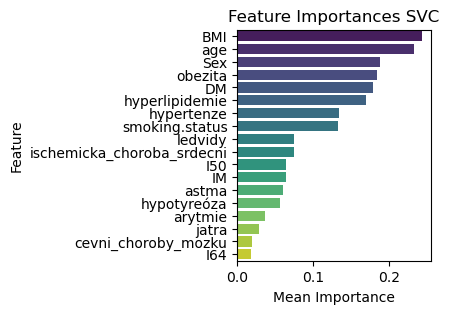

In [461]:
plt.figure(figsize=(2.5,3))

sns.barplot(x='Importance', y='Feature', data=feature_importances_svc, palette='viridis')

plt.title('Feature Importances SVC')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')

plt.show()

#### SVR

In [403]:
X = df_copy.drop(['Sy_spankove_apnoe', 'AHI', 'delka_DM'], axis=1)
y = df_copy['AHI']

ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in ss.split(X, y):
    strat_train = df_copy.loc[train_index]
    strat_test = df_copy.loc[test_index]

X_train = strat_train.drop(columns=['Sy_spankove_apnoe', 'AHI', 'delka_DM'])
y_train = strat_train['AHI']
X_test = strat_test.drop(columns=['Sy_spankove_apnoe', 'AHI', 'delka_DM'])
y_test = strat_test['AHI']


pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Normalization step
    ('classifier', SVR())  # You can replace this with any other classifier
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],          # Regularization parameter
    'classifier__kernel': ['linear', 'poly'],    # Kernel type
    'classifier__epsilon': [0.001, 0.01, 0.1, 1, 10]  # Kernel coefficient for 'rbf' and 'poly'
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10)  

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps['classifier']
    
res = permutation_importance(grid_search, X_train, y_train, n_repeats=10, random_state=42).importances_mean
feature_importances_svr = pd.DataFrame({
    'Feature': feature_names,
    'Importance': res
}).sort_values(by='Importance', ascending=False)

print(feature_importances_svr)

Best parameters found:  {'classifier__C': 1, 'classifier__epsilon': 10, 'classifier__kernel': 'linear'}
Best cross-validation score:  0.00455725229370828
                       Feature    Importance
2                          BMI  1.668358e-01
0                          Sex  7.011183e-02
16                 hypotyreóza  4.359604e-02
1                          age  2.616365e-02
4                           DM  9.433619e-03
5                   hypertenze  7.216633e-03
11                     arytmie  6.521247e-03
6   ischemicka_choroba_srdecni  6.338751e-03
17                     ledvidy  5.021796e-03
14              hyperlipidemie  4.186195e-03
3               smoking.status  3.448831e-03
15                       astma  1.387358e-03
12                       jatra  2.606529e-04
7                           IM  3.178373e-05
8                          I50  3.178373e-05
9                          I64 -2.220446e-17
10         cevni_choroby_mozku -4.440892e-17
13                     obezita -2.03

/tmp/ipykernel_2147270/529037598.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_svr, palette='viridis')


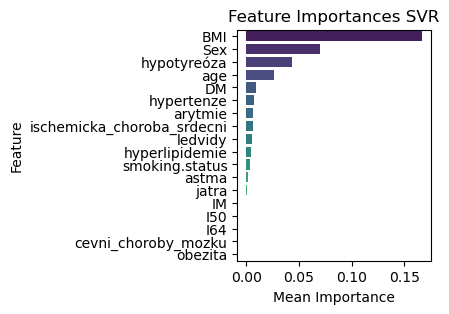

In [463]:
plt.figure(figsize=(2.5,3))

sns.barplot(x='Importance', y='Feature', data=feature_importances_svr, palette='viridis')

plt.title('Feature Importances SVR')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')

plt.show()

In [455]:
feature_importances_rfc.merge(feature_importances_svc, left_on='Feature', right_on='Feature', how='left')

,Feature,Importance_x,Importance_y
0,age,0.282194,0.231564
1,BMI,0.280173,0.242458
2,obezita,0.046265,0.183520
3,hyperlipidemie,0.045939,0.169553
4,smoking.status,0.044404,0.131844
5,delka_DM,0.042821,NaN
6,DM,0.038420,0.178492
7,hypertenze,0.037205,0.134078
8,Sex,0.033206,0.187709
9,ledvidy,0.026762,0.074022
